In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score



from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
df = pd.read_csv("cardio_train.csv", sep = ';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


/tmp/ipython-input-3428078332.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cardio',data=df,palette='hls')


<Axes: xlabel='cardio', ylabel='count'>

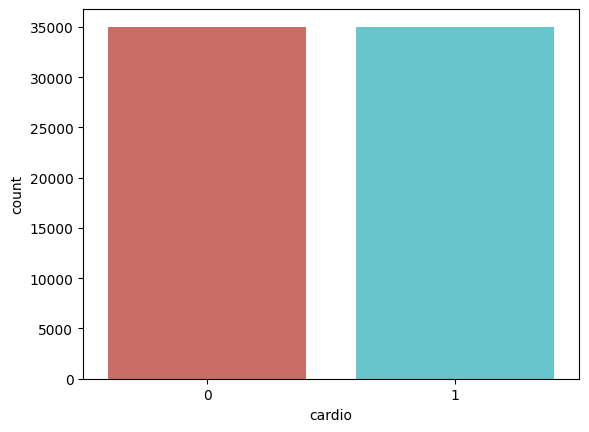

In [5]:
sns.countplot(x='cardio',data=df,palette='hls')

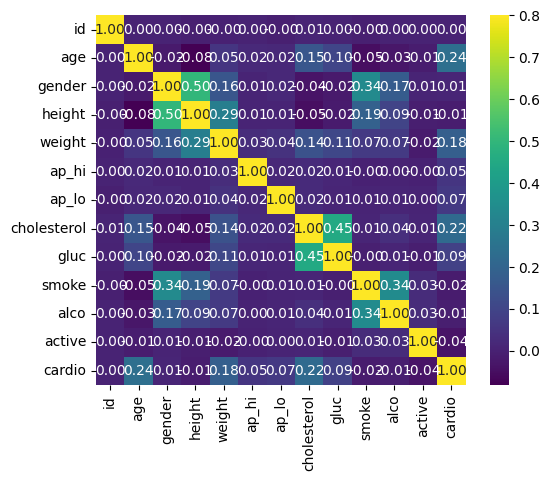

In [6]:
# Draw a heatmap
indexes = df.columns# Use all features for the heatmap
selected_features = df[indexes]
df2 = pd.DataFrame(selected_features, columns = df.columns)
df2['cardio'] = df['cardio']
corrmat = df2.corr()
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, annot=True, fmt='.2f', cmap='viridis')
plt.savefig("corrplot.png", dpi = 300, bbox_inches = 'tight')

In [7]:
# Filtrar alçades fora de rang
df = df[(df['height'] >= 120) & (df['height'] <= 220)]

# Filtrar pesos fora de rang
df = df[(df['weight'] >= 30) & (df['weight'] <= 200)]


In [8]:
# Calculem BMI i eliminem les columnes de height i weight
if {'height', 'weight'}.issubset(df.columns):
    df['height_m'] = df['height'] / 100.0
    df['bmi'] = df['weight'] / (df['height_m']**2)
    df = df.drop(columns={'height','height_m','weight'})

In [9]:
df

,id,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,18393,2,110,80,1,1,0,0,1,0,21.967120
1,1,20228,1,140,90,3,1,0,0,1,1,34.927679
2,2,18857,1,130,70,3,1,0,0,0,1,23.507805
3,3,17623,2,150,100,1,1,0,0,1,1,28.710479
4,4,17474,1,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,120,80,1,1,1,0,1,0,26.927438
69996,99995,22601,1,140,90,2,2,0,0,1,1,50.472681
69997,99996,19066,2,180,90,3,1,0,1,0,1,31.353579
69998,99998,22431,1,135,80,1,2,0,0,0,1,27.099251


In [10]:
# Convertim l'edat a anys
df['age_in_years'] = (df['age']/365).astype(int)
df = df.drop(columns='age')

In [11]:
df.columns

Index(['id', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'alco', 'active', 'cardio', 'bmi', 'age_in_years'],
      dtype='object')

In [12]:
# Eliminem quan la low ap sigui més gran que la high ap
df = df[df['ap_lo'] <= df['ap_hi']]

# Filtrem que les ap estiguin dins dels valors considerats normals
df = df[(df['ap_hi'] >= 60) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 40) & (df['ap_lo'] <= 200)]

In [13]:
# Afegim la variable Pulse Pressure
df["pulse_pressure"] = df["ap_hi"] - df["ap_lo"]

/tmp/ipython-input-3086385004.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_in_years',data=df,palette='hls')


<Axes: xlabel='age_in_years', ylabel='count'>

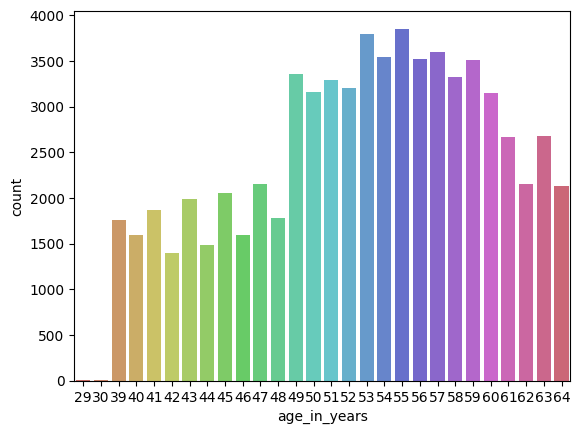

In [14]:
#Representació de la distribució de age_in_years
sns.countplot(x='age_in_years',data=df,palette='hls')

/tmp/ipython-input-1634282539.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender',data=df,palette='hls')


<Axes: xlabel='gender', ylabel='count'>

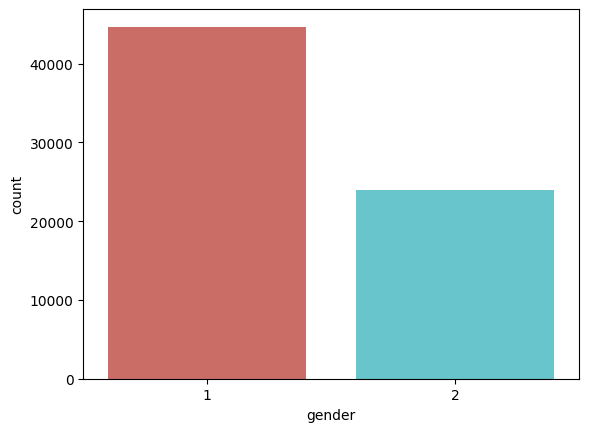

In [15]:
#Representació de la distribució de gender
sns.countplot(x='gender',data=df,palette='hls')

<Axes: xlabel='ap_hi', ylabel='Count'>

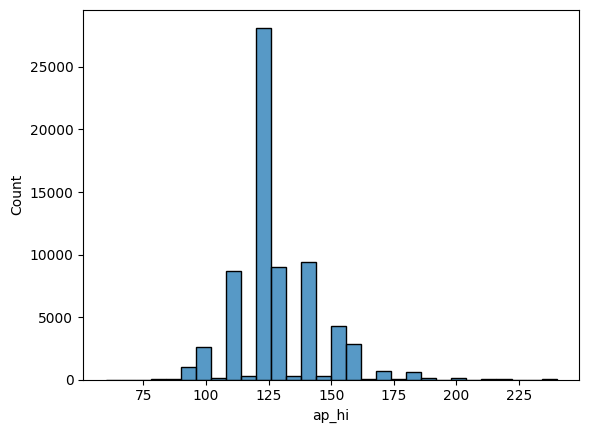

In [16]:
#Representació de la distribució de ap_hi
sns.histplot(df["ap_hi"], bins=30)


<Axes: xlabel='ap_lo', ylabel='Count'>

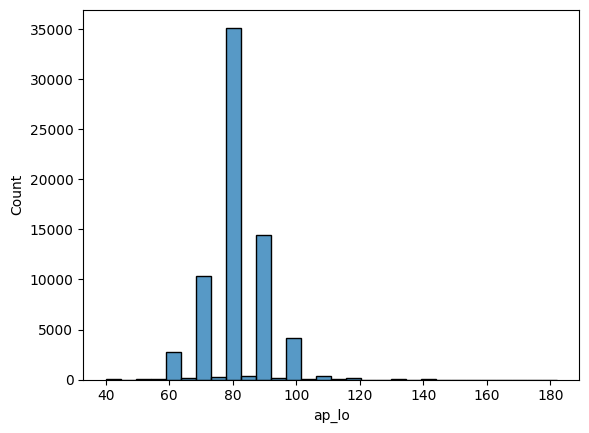

In [17]:
#Representació de la distribució de ap_lo
sns.histplot(df["ap_lo"], bins=30)


<Axes: xlabel='pulse_pressure', ylabel='Count'>

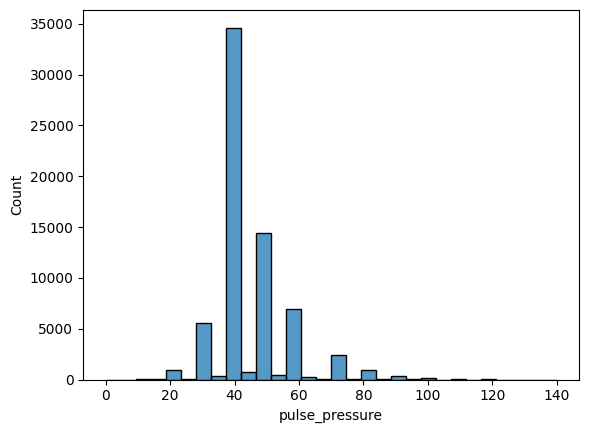

In [18]:
#Representació de la distribució de pulse pressure
sns.histplot(df["pulse_pressure"], bins=30)


/tmp/ipython-input-2930408616.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cholesterol',data=df,palette='hls')


<Axes: xlabel='cholesterol', ylabel='count'>

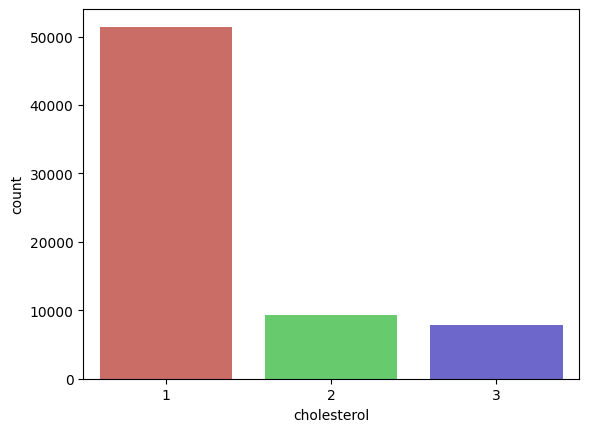

In [19]:
#Representació de la distribució de cholesterol
sns.countplot(x='cholesterol',data=df,palette='hls')

/tmp/ipython-input-3314704156.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gluc',data=df,palette='hls')


<Axes: xlabel='gluc', ylabel='count'>

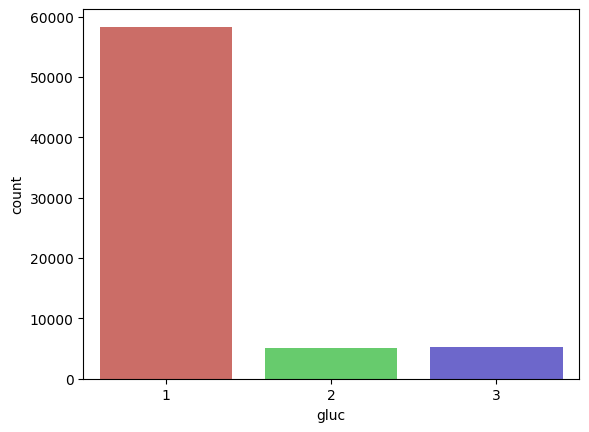

In [20]:
#Representació de la distribució de gluc

sns.countplot(x='gluc',data=df,palette='hls')

/tmp/ipython-input-2067606016.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='alco',data=df,palette='hls')


<Axes: xlabel='alco', ylabel='count'>

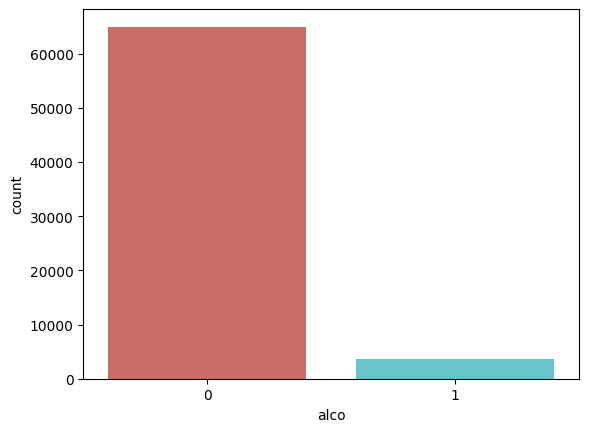

In [21]:
#Representació de la distribució de alco
sns.countplot(x='alco',data=df,palette='hls')

/tmp/ipython-input-1721862312.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='smoke',data=df,palette='hls')


<Axes: xlabel='smoke', ylabel='count'>

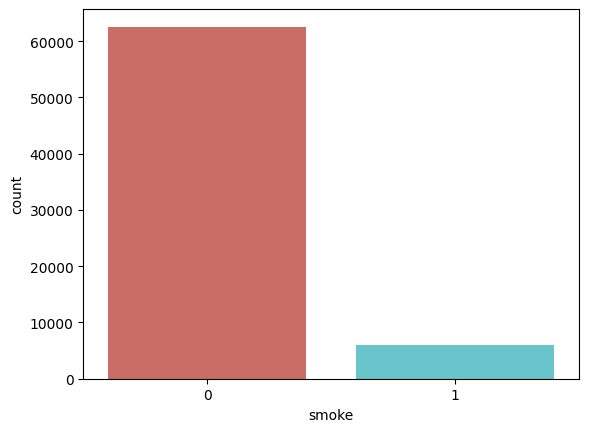

In [22]:
#Representació de la distribució de smoke
sns.countplot(x='smoke',data=df,palette='hls')

/tmp/ipython-input-1930391288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='active',data=df,palette='hls')


<Axes: xlabel='active', ylabel='count'>

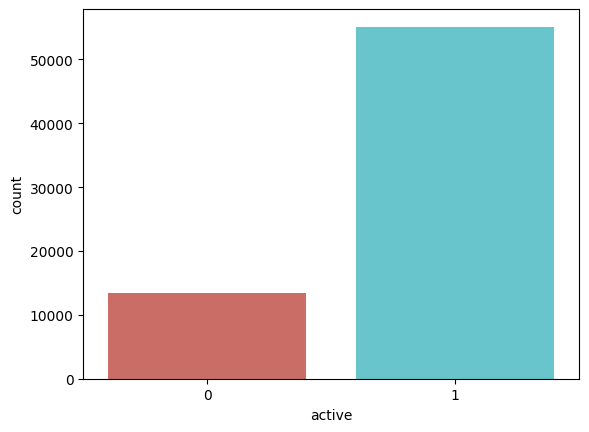

In [23]:
#Representació de la distribució de active
sns.countplot(x='active',data=df,palette='hls')

<Axes: xlabel='bmi', ylabel='Count'>

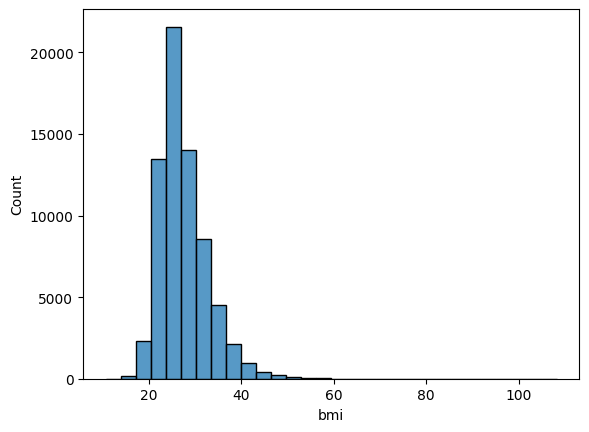

In [24]:
#Representació de la distribució de bmi
sns.histplot(df["bmi"], bins=30)

Correlacions

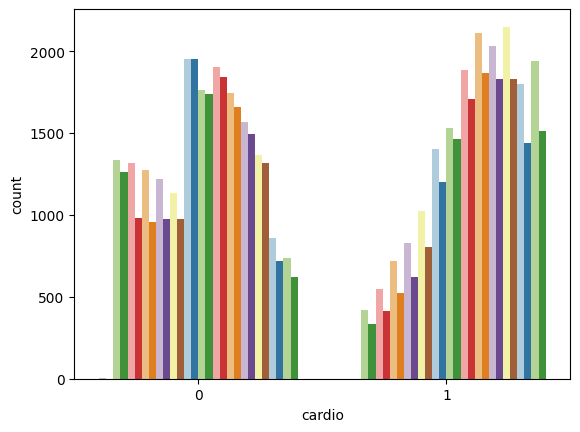

In [25]:
#Correlació age i target
sns.countplot(x='cardio',hue='age_in_years',data=df,palette='Paired')
plt.legend().remove()


<Axes: xlabel='cardio', ylabel='count'>

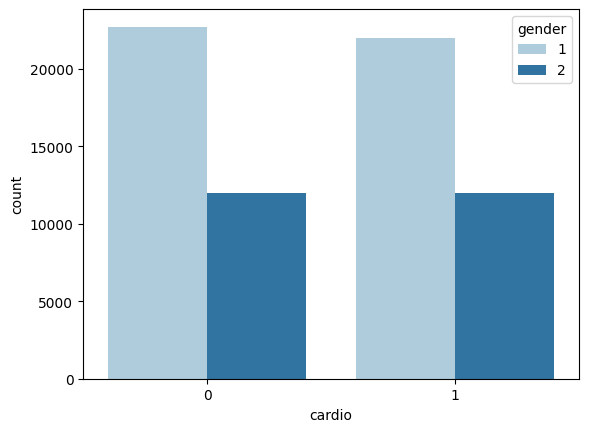

In [26]:
#Correlació gender i target
sns.countplot(x='cardio',hue='gender',data=df,palette='Paired')

<Axes: xlabel='cardio', ylabel='count'>

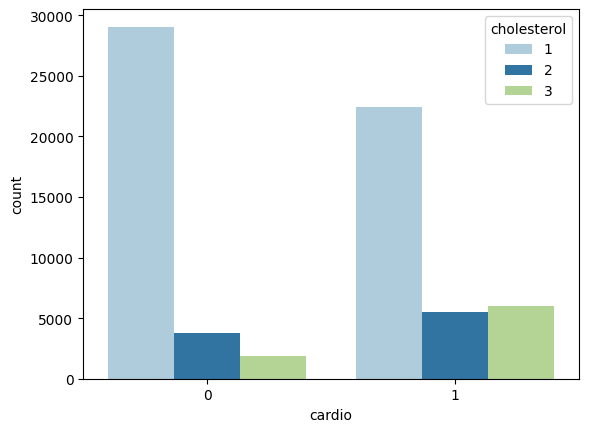

In [27]:
#Correlació cholesterol i target
sns.countplot(x='cardio',hue='cholesterol',data=df,palette='Paired')

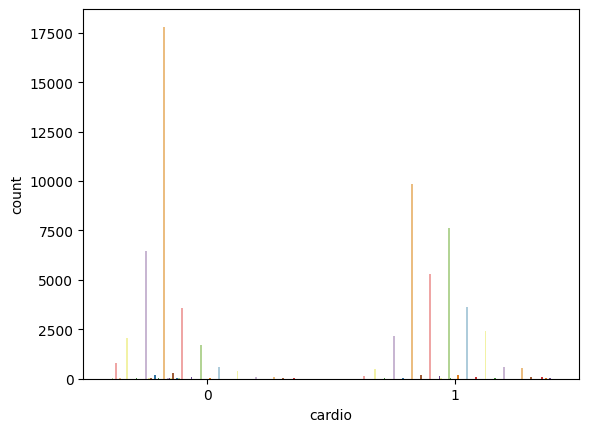

In [28]:
#Correlació ap_hi i target
sns.countplot(x='cardio',hue='ap_hi',data=df,palette='Paired')
plt.legend().remove()


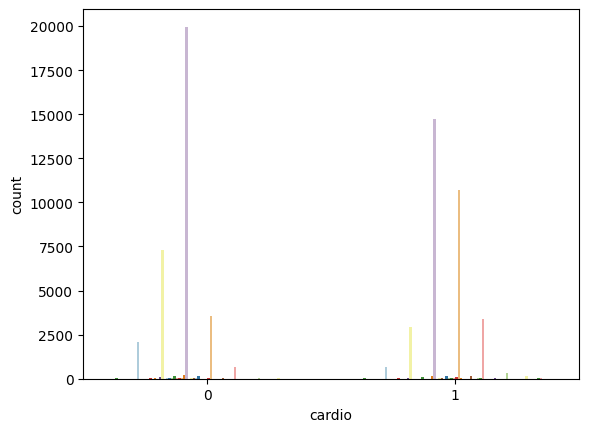

In [29]:
#Correlació ap_lo i target
sns.countplot(x='cardio',hue='ap_lo',data=df,palette='Paired')
plt.legend().remove()


<Axes: xlabel='cardio', ylabel='count'>

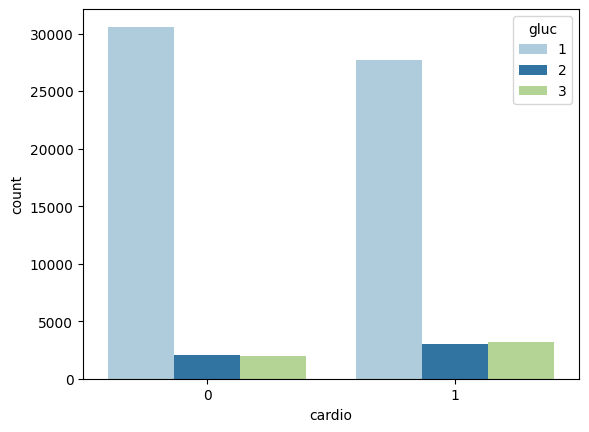

In [30]:
#Correlació gluc i target
sns.countplot(x='cardio',hue='gluc',data=df,palette='Paired')

<Axes: xlabel='cardio', ylabel='count'>

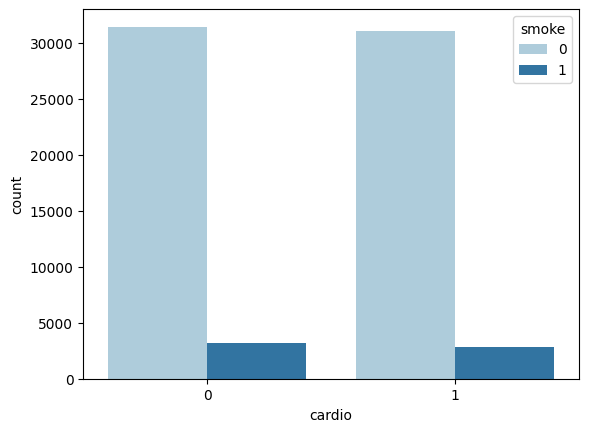

In [31]:
#Correlació smoke i target
sns.countplot(x='cardio',hue='smoke',data=df,palette='Paired')

<Axes: xlabel='cardio', ylabel='count'>

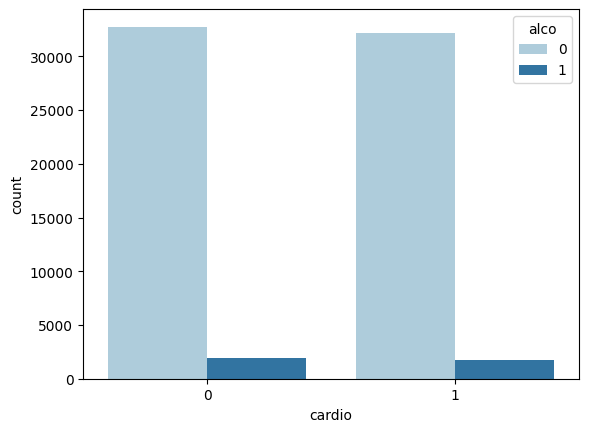

In [32]:
#Correlació alco i target
sns.countplot(x='cardio',hue='alco',data=df,palette='Paired')

<Axes: xlabel='cardio', ylabel='count'>

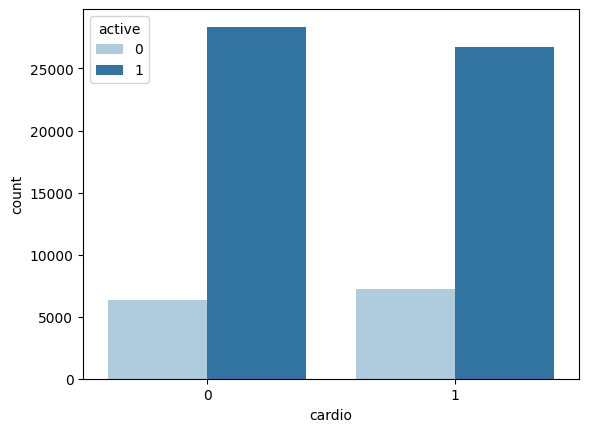

In [33]:
#Correlació active i target
sns.countplot(x='cardio',hue='active',data=df,palette='Paired')

In [34]:
df.columns

Index(['id', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'alco', 'active', 'cardio', 'bmi', 'age_in_years', 'pulse_pressure'],
      dtype='object')

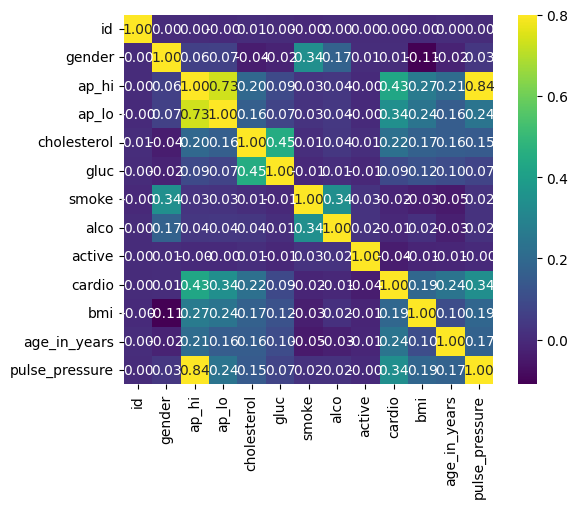

In [35]:
# Draw a heatmap
indexes = df.columns# Use all features for the heatmap
selected_features = df[indexes]
df2 = pd.DataFrame(selected_features, columns = df.columns)
df2['cardio'] = df['cardio']
corrmat = df2.corr()
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, annot=True, fmt='.2f', cmap='viridis')
plt.savefig("corrplot.png", dpi = 300, bbox_inches = 'tight')

In [36]:
#Normalitzem les variables que no són categòriques
df["age__in_years_scaled"] = (df["age_in_years"] - df["age_in_years"].mean()) / df["age_in_years"].std()
df["ap_hi_scaled"] = (df["ap_hi"] - df["ap_hi"].mean()) / df["ap_hi"].std()
df["ap_lo_scaled"] = (df["ap_lo"] - df["ap_lo"].mean()) / df["ap_lo"].std()
df["bmi_scaled"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()

In [37]:
X = df.drop(columns=["cardio"])
y = df["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [38]:
model = LinearRegression().fit(X_train, y_train)
print("Coeficients del model:", model.coef_)

Coeficients del model: [ 5.52372595e-08  5.90231853e-03  7.30768395e-03  4.83748640e-03
  9.64331504e-02 -1.89150468e-02 -2.75783987e-02 -3.58961385e-02
 -4.40691013e-02  5.36275230e-03  1.01085625e-02  2.47019755e-03
  1.49336559e-03  4.37780607e-04  5.11727093e-04  1.02005318e-03]


In [39]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [40]:

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [41]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [42]:
results = []

# LOGISTIC REGRESSION
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
results.append({
    "Model": "Regressio Logistica",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
})


# KNN
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]
results.append({
    "Model": "kNN",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
})

# RANDOM FOREST
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
})

In [43]:
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy    Recall        F1   AUC-ROC
0  Regressio Logistica  0.731929  0.668094  0.710975  0.790864
1                  kNN  0.653162  0.588661  0.626198  0.696447
2        Random Forest  0.709268  0.688617  0.700405  0.774498
